In [330]:
import numpy as np
import matplotlib.pyplot as plt

In [331]:
num_samples = 1000
num_dimensions = 2
num_classes = 3

In [332]:
def make_data(num_items):
    data = []
    
    for _ in range(num_items):
        item = np.random.exponential(1, num_dimensions)
        
        # Randomly make some values negative
        for dim in range(num_dimensions):
            if np.random.rand() < 0.5:
                item[dim] = -1 * item[0]
            
        data.append(item)
    
    return np.asarray(data)

def makeMeans():
    # Subtract .5 so some are negative
    means = make_data(num_classes) - .5
    means = means * 20
    return np.array(means)

def makeClassProb():
    class_prob = [np.random.random() for _ in range(num_classes)]
    s = sum(class_prob)
    class_prob = [ i/s for i in class_prob]
    return class_prob
    
# Randomly generate the data from exponentials
def generate():
    # Generate random probabilities for each class
    class_prob = makeClassProb()
    
    # Generate random means
    means = makeMeans()

    samples = []
    
    # Generate data for each class
    for i in range(num_classes):
        # + 1 for laplace smoothing
        class_samples = make_data((int)(num_samples * class_prob[i]) + 1)
        class_samples = class_samples + means[i]
        class_samples = np.asarray(class_samples)
        
        samples.extend(class_samples)

    samples = np.asarray(samples)
    
    # Shuffle the data so we mix up the various classes
    np.random.shuffle(samples)
    return samples, means, class_prob
        
samples, means, class_prob = generate()


In [333]:
def expectation(dataset, means, class_prob):    
    # Every values associated class responsibilities
    output = []
    
    for value in dataset:
        numerators = []
        
        # For each class
        for index in range(num_classes):
        
            mean = means[index]
        
            #P(k) 
            k_prob = class_prob[index]
        
            #P(x | mk)
            conditional_prob = np.exp(-1 * np.linalg.norm(value - mean))

            numerators.append(k_prob * conditional_prob)
        
        # Normalize
        rnk = numerators / np.sum(numerators)
        
        output.append(rnk)
        
    return np.asarray(output)


In [334]:
# Calculate responsibility for each class
def calculate_responsibilities(responsibilities):
    allClassesResponsibility = []
    
    for index in range(num_classes):
        # Sum for all xs for this class
        classResponsibility = np.sum(responsibilities[:,index])
        allClassesResponsibility.append(classResponsibility)
            
    # Sum for all values for all classes
    totalResponsibility = np.sum(allClassesResponsibility)
    
    # pi K
    return allClassesResponsibility / totalResponsibility


# Calculate mean for each class
def calculate_means(responsibilities, dataset, means):
    allClassesMeans = []
    
    for index in range(num_classes):
        numerators = []
        denominators = []
        
        for n in range(len(dataset)):
            value = dataset[n]
            
            # Euclidean distance between class mean and this value
            distance = np.abs(means[index] - value)
            
            # Protect against divide by zero by adding small number if the value is zero
            distance = np.where(distance == 0, 0.0001, distance)
                     
            # Xn / distance
            two = value / distance
            
            classResponsibility = responsibilities[n, index]
            
            numerator = classResponsibility * two
            denominator = (classResponsibility / distance )

            numerators.append(numerator)
            denominators.append(denominator)
        
        updatedMean = np.sum(numerators, axis=0) / np.sum(denominators, axis=0)
        allClassesMeans.append(updatedMean)
    
    return np.asarray(allClassesMeans)

#Update the parameters (pik, mk)
def maximization(responsibilities, dataset, means):        
    updatedMeans = calculate_means(responsibilities, dataset, means)
    updatedResponsibilities = calculate_responsibilities(responsibilities)

    return updatedMeans, updatedResponsibilities
        
    


In [335]:
def em(samples):
    # Start off with random class probs and means
    updated_class_prob = makeClassProb()
    updated_means = makeMeans()
    
    # Track how the means change (for graphing)
    meanHistory = [updated_means]
    
    
    # How much of a change to consider progress
    threshold = 0.001
    # Value doesnt matter for first iteration, just needs to be bigger than threshold so loop runs
    change = threshold + 1 

    # While the means are changing, keep running E and M steps
    while change > threshold:
        responsibilities = expectation(samples, updated_means, updated_class_prob)
        updated_means, updated_class_prob = maximization(responsibilities, samples, updated_means)
        # Difference between last means and current means
        change = np.sum(np.abs(meanHistory[-1] - updated_means))
        meanHistory.append(updated_means)
    
    # Return all the means, so they can be graphed
    return np.asarray(meanHistory)

In [336]:
meanHistory = em(samples)

In [337]:
def plot_data(samples, real_means, mean_history):  
    plt.scatter(samples[:,0].flatten(), samples[:,1].flatten(), c="B")
    plt.scatter(means[:,0], means[:,1], c="R")
    for i in range(num_classes):
        plt.plot(meanHistory[:,i][:,0], meanHistory[:,i][:,1], c="G")
    plt.show()

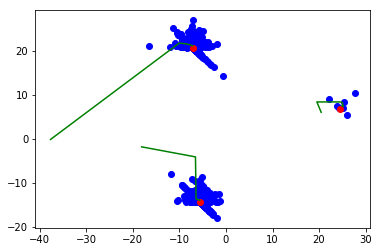

In [338]:
plot_data(samples, means, meanHistory)